In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import glob
import os
import os.path as osp
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2 as transforms
from torchvision.utils import make_grid
from PIL import Image
from torchvision.io import read_image, ImageReadMode
import torch.nn.functional as F
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import time
import pickle
import datetime
import json
import cv2
import segmentation_models_pytorch as smp

from torchvision.datasets import ImageFolder
from dataset import TumorSegmentationDataset
from visualization import TrainingPlotter, set_ax_borders, plot_cm, plot_class_distribution
from utils import Logger, SynchronizedTransform, get_lr_scheduler, get_current_lr, save_weights, load_weights
from runners import EpochRunner
from metrics import accuracy, precision, recall, f1_score, IoU
from model import TumorSegmentationModel

d:\Developer\anaconda3\envs\genomtechlab\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_data_path = './Data/Segmentation/train/'
valid_data_path = './Data/Segmentation/valid/'
test_data_path  = './Data/Segmentation/test/'

In [3]:
def read_data(data_path):
    img_pths = glob.glob(osp.join(data_path,"*.jpg"))
    img_pths_dict = {osp.basename(img):img for img in img_pths}
    
    ann_pth = glob.glob(osp.join(data_path,"*.json"))[0]
    ann_file = json.load(open(ann_pth))
    ann_dict = {ann['id']:ann for ann in ann_file['annotations']}
    img_dict = {img['id']:img for img in ann_file['images']}

    all_info = [
        {
            'ann_info': ann_dict.get(_id, {}),
            'img_info': img_dict.get(_id, {}),
            'img_path': img_pths_dict.get(img_dict[_id]['file_name'])
        }
        for _id in img_dict
    ]
    
    return all_info

train_data = read_data(train_data_path)
valid_data = read_data(valid_data_path)
test_data  = read_data(test_data_path)

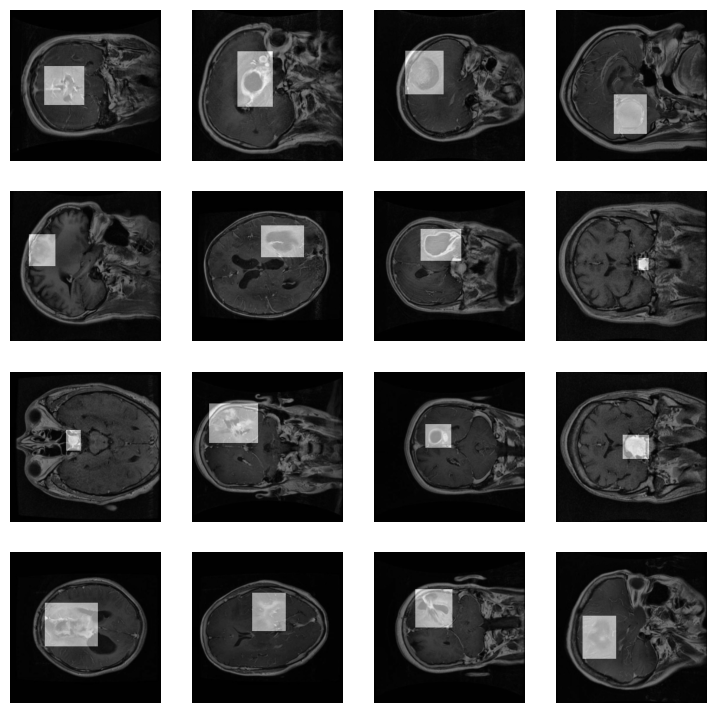

In [4]:
transform_pipeline = SynchronizedTransform(size=(256, 256), crop_size=(224, 224), randomize=False)

sample_ds = TumorSegmentationDataset(train_data, transform_pipeline)

fig, axes = plt.subplots(ncols=4, nrows=4)
axes = axes.flatten()
fig.set_size_inches(9,9)
for i in range(16):
    img, mask = sample_ds[i]
    axes[i].imshow(img[0], cmap='gray')
    axes[i].imshow(mask[0], alpha=0.5, cmap='gray')
    axes[i].set_axis_off()
plt.show()

In [5]:
BASE_LR = 1e-3
WEIGHTS = None
now = datetime.datetime.now()
WORK_DIR = "./experiments/segmentation/exp_" + now.strftime("%m-%d-%y_%H-%M")
EPOCHS = 30
BATCH_SIZE = 64
if os.path.exists(osp.join(WORK_DIR, 'train_log.txt')):
    os.remove(osp.join(WORK_DIR, 'train_log.txt'))
os.makedirs(WORK_DIR, exist_ok=True)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

transform_pipeline = SynchronizedTransform(size=(224, 224), crop_size=(224, 224), randomize=False)

train_dataset = TumorSegmentationDataset(train_data, transform_pipeline)
val_dataset   = TumorSegmentationDataset(valid_data, transform_pipeline)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)
val_dataloader   = DataLoader(val_dataset,   batch_size = BATCH_SIZE, shuffle = False)

model = smp.Unet('resnet50', encoder_weights='imagenet', in_channels=1, classes=1, activation=None)
#model = TumorSegmentationModel(resnet_type='resnet50', input_channels=1, num_classes=1, weights=True)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=BASE_LR)
iterations_per_epoch = len(train_dataloader)
scheduler = get_lr_scheduler(optimizer, 'CosineAnnealingLRwithWarmupFixed', EPOCHS, iterations_per_epoch, {'min_lr': BASE_LR*0.1, 'start_factor': 0.1})

model.to(DEVICE);

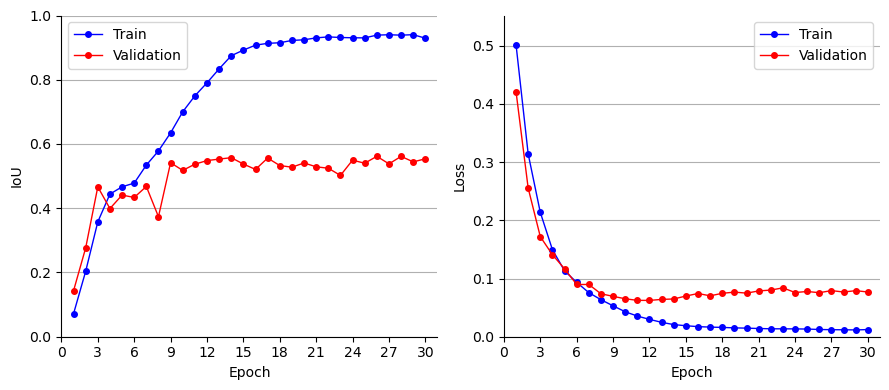

2024-12-09 20:58:48,232 - INFO - Training parameters:
2024-12-09 20:58:48,232 - INFO - Base learning rate: 0.001
2024-12-09 20:58:48,233 - INFO - Number of parameters: 32514833
2024-12-09 20:58:48,233 - INFO - Device: cuda
2024-12-09 20:58:48,233 - INFO - Training for 30 epochs
[Epoch 1   Training]: 100%|██████████| 24/24 [00:26<00:00,  1.11s/it]
2024-12-09 20:59:15,314 - INFO - [Epoch: 001]      Train info: Loss: 0.5017, Iou: 0.0714, LR: 0.000250
[Epoch 1 Validating]: 100%|██████████| 7/7 [00:05<00:00,  1.20it/s]
2024-12-09 20:59:21,235 - INFO - [Epoch: 001] Validation info: Loss: 0.4211, Iou: 0.1430
[Epoch 2   Training]: 100%|██████████| 24/24 [00:15<00:00,  1.53it/s]
2024-12-09 20:59:39,287 - INFO - [Epoch: 002]      Train info: Loss: 0.3141, Iou: 0.2036, LR: 0.000400
[Epoch 2 Validating]: 100%|██████████| 7/7 [00:03<00:00,  2.17it/s]
2024-12-09 20:59:42,608 - INFO - [Epoch: 002] Validation info: Loss: 0.2553, Iou: 0.2764
[Epoch 3   Training]: 100%|██████████| 24/24 [00:15<00:00,  1

In [6]:
TRAIN=True
if TRAIN: 
    plotter = TrainingPlotter("IoU")

    num_params = sum(p.numel() for p in model.parameters())
    train_logger = Logger('train', osp.join(WORK_DIR, 'train_log.txt'))

    train_logger.log_message(f"Training parameters:")
    train_logger.log_message(f"Base learning rate: {BASE_LR}")
    train_logger.log_message(f"Number of parameters: {num_params}")
    train_logger.log_message(f"Device: {DEVICE}")

    epoch_runner = EpochRunner(model, DEVICE, optimizer, criterion, scheduler, [IoU])
    train_logger.log_message(f"Training for {EPOCHS} epochs")
    best_val_acc = -1

    try:
        for epoch in range(EPOCHS):
            train_metrics, train_loss = epoch_runner.run_epoch('train', epoch, train_dataloader)
            current_lr = get_current_lr(optimizer)[0]
            train_logger.log_training(epoch + 1, train_loss, train_metrics, current_lr)

            val_metrics, val_loss, _, _, _ = epoch_runner.run_epoch('validate', epoch, val_dataloader)
            train_logger.log_validation(epoch + 1, val_loss, val_metrics)

            plotter.update(epoch, train_metrics['IoU'], val_metrics['IoU'], train_loss, val_loss)

            val_acc = val_metrics['IoU']
            save_weights(model, f"epoch_{epoch + 1:03d}.pth", WORK_DIR)
            if val_acc > best_val_acc:
                best_epoch_name_str = f"best_val_results_epoch_{epoch + 1:03d}_acc_{val_acc:.2f}.pth"
                save_weights(model, best_epoch_name_str, WORK_DIR, "best_val_results")
                best_val_acc = val_acc
    except KeyboardInterrupt:
        train_logger.log_message(f"Training interrupted by user")
        
    train_logger.log_message(f"Training completed")
    train_logger.log_message(f"Best validation IoU: {best_val_acc}")
    train_logger.close()

    plotter.save_plot(osp.join(WORK_DIR, 'training_plot.png'))
    plotter.close()

In [7]:
transform_pipeline = SynchronizedTransform(size=(256, 256), crop_size=(224, 224), randomize=False)

test_dataset = TumorSegmentationDataset(test_data, transform_pipeline)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

if os.path.exists(osp.join(WORK_DIR, 'test_log.txt')):
    os.remove(osp.join(WORK_DIR, 'test_log.txt'))
    
best_weights = glob.glob(osp.join(WORK_DIR, "best_val_*.pth"))[0]
load_weights(model, best_weights)

epoch_runner = EpochRunner(model, DEVICE, optimizer, criterion, None, [IoU])

test_logger = Logger('test', osp.join(WORK_DIR, 'test_log.txt'))
test_logger.log_message(f"Testing with best weights from {best_weights}")
test_logger.log_message(f"Testing")
test_metrics, test_loss, test_preds, test_gts, test_feats = epoch_runner.run_epoch('test', 0, test_dataloader)
test_logger.log_test(1, test_loss, test_metrics)

test_logger.log_message(f"Testing completed")
metrics_str = ", ".join([f"{k}: {v:.4f}" for k, v in test_metrics.items()])
test_logger.log_message(f"Test metrics: {metrics_str}")
test_logger.close()

2024-12-09 21:09:15,225 - INFO - Testing with best weights from ./experiments/segmentation/exp_12-09-24_20-58\best_val_results_epoch_026_acc_0.56.pth
2024-12-09 21:09:15,226 - INFO - Testing
[Epoch 1    Testing]: 100%|██████████| 7/7 [00:01<00:00,  3.89it/s]
2024-12-09 21:09:17,088 - INFO - [Epoch: 001]       Test info: Loss: 0.0930, Iou: 0.4593
2024-12-09 21:09:17,089 - INFO - Testing completed
2024-12-09 21:09:17,089 - INFO - Test metrics: IoU: 0.4593


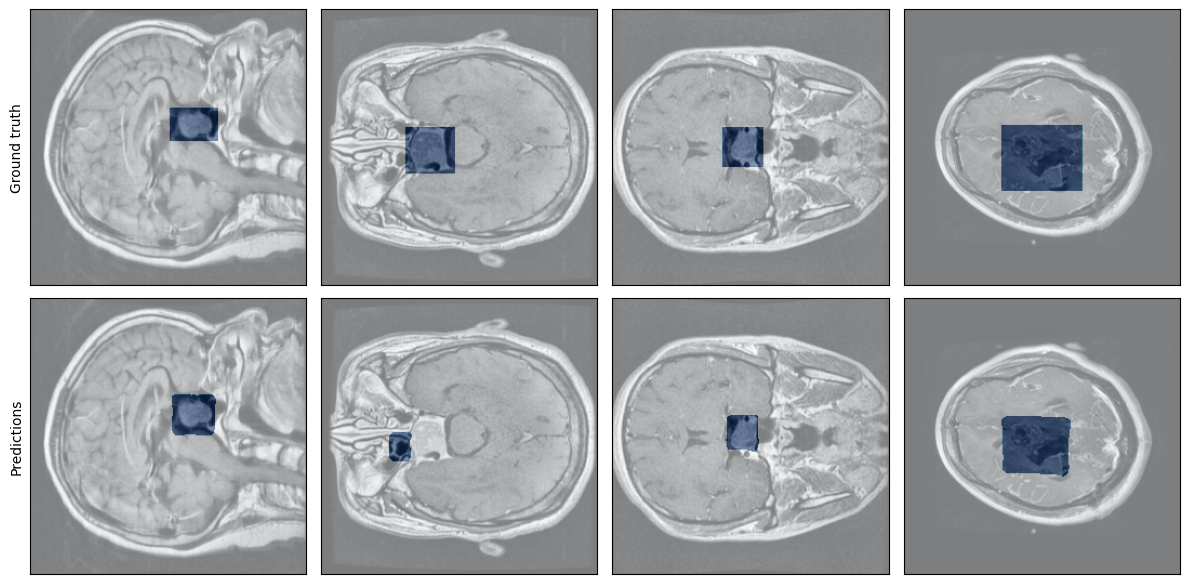

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

fig, axes = plt.subplots(ncols=4, nrows=2)
fig.set_size_inches(12, 6)
for i in range(4):
    img, mask = test_dataset[i]
    img = img.unsqueeze(0)
    mask = mask.unsqueeze(0)
    pred = model(img.to(DEVICE)).detach().cpu().numpy()
    pred = sigmoid(pred)>0.5
    axes[0, i].imshow(img[0, 0], cmap='gray')
    axes[0, i].imshow(mask[0, 0], alpha=0.5, cmap='Blues')
    axes[1, i].imshow(img[0, 0], cmap='gray')
    axes[1, i].imshow(pred[0, 0], alpha=0.5, cmap='Blues')
for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_xticks([], minor=True)
    ax.set_yticks([])
    ax.set_yticks([], minor=True)
axes[0, 0].set_ylabel("Ground truth")
axes[1, 0].set_ylabel("Predictions")
fig.tight_layout()